# Conversational RAG Example

In [2]:
# Importing the necessary libraries
import pprint
from typing import Tuple
from hamilton import dataflows, driver
import burr.core
from burr.core import ApplicationBuilder, State, default, expr
from burr.core.action import action
from application import PrintStepHook # local import from application.py
from burr.tracking import LocalTrackingClient

# Load your "chain" or conversational RAG "pipeline"

We use Hamilton here. But you could use LangChain, etc., or forgo them and write your own code.

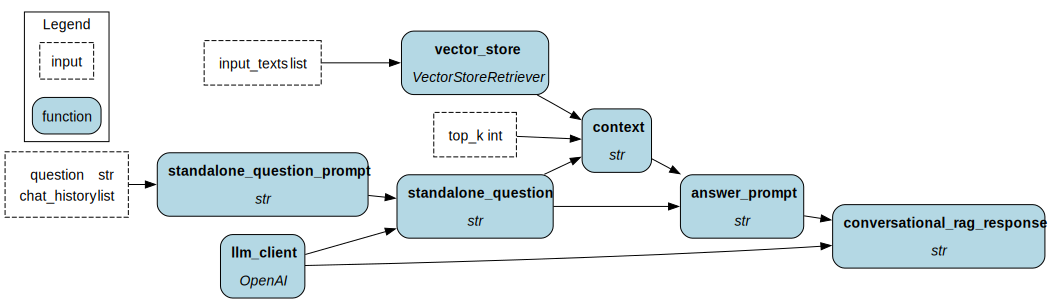

In [4]:
# Loads Hamilton DAG
conversational_rag = dataflows.import_module("conversational_rag")
conversational_rag_driver = (
    driver.Builder()
    .with_config({})  # replace with configuration as appropriate
    .with_modules(conversational_rag)
    .build()
)
conversational_rag_driver.display_all_functions()

# Create the actions that will constitute our application

We will use the functional (vs class) approach to declaring actions here. 

In [5]:
@action(
    reads=["question", "chat_history"],
    writes=["chat_history"],
)
def ai_converse(state: State, vector_store: object) -> Tuple[dict, State]:
    """AI conversing step. Uses Hamilton to execute the conversational pipeline."""
    result = conversational_rag_driver.execute(
        ["conversational_rag_response"],
        inputs={
            "question": state["question"],
            "chat_history": state["chat_history"],
        },
        # we use overrides here because we want to pass in the vector store
        overrides={
            "vector_store": vector_store,
        }
    )
    new_history = f"AI: {result['conversational_rag_response']}"
    return result, state.append(chat_history=new_history)


@action(
    reads=[],
    writes=["question", "chat_history"],
)
def human_converse(state: State, user_question: str) -> Tuple[dict, State]:
    """Human converse step -- make sure we get input, and store it as state."""
    state = state.update(question=user_question).append(chat_history=f"Human: {user_question}")
    return {"question": user_question}, state

# Create the application

We now create the application, which is a collection of actions, and then set the transitions between the actions based on values in State.

We also intialize initial values etc to populate the application with.

In [12]:
# what we will do RAG over.
initial_documents = [
    "harrison worked at kensho",
    "stefan worked at Stitch Fix",
    "stefan likes tacos",
    "elijah worked at TwoSigma",
    "elijah likes mango",
    "stefan used to work at IBM",
    "elijah likes to go biking",
    "stefan likes to bake sourdough",
]
# bootstrap the vector store;
vector_store = conversational_rag_driver.execute(
    ["vector_store"],
    inputs={"input_texts": initial_documents})["vector_store"]
# what we will initialize the application with
initial_state = {
    "question": "",
    "chat_history": [],
}
import uuid
app_id = str(uuid.uuid4())
app = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=app_id, partition_key="sample_user")
    # initialize the state
    .with_state(**initial_state)
    # say what the initial action is
    .with_entrypoint("human_converse")
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(project="demo:conversational-rag")
    # build the application
    .build()
)

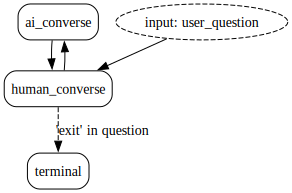

In [13]:
# let's visualize what we have
app.visualize(include_conditions=True)

# Let's run the app. 

Let's run it a step at a time.

In [14]:
app.reset_to_entrypoint() # reset the app to the entrypoint
user_question = input("Ask something (or type exit to quit): ")
previous_action, result, state = app.step(
    inputs={"user_question": user_question},
)
print(f"Ran action {previous_action.name} with result:\n {pprint.pformat(result)} \n and state:\n {pprint.pformat(state.get_all())}")

Ask something (or type exit to quit):  who is Stefan? Answer in English.


⏳Processing input from user...
🎙💬 who is Stefan? Answer in English. 

Ran action human_converse with result:
 {'question': 'who is Stefan? Answer in English.'} 
 and state:
 {'__PRIOR_STEP': 'human_converse',
 '__SEQUENCE_ID': 0,
 'chat_history': ['Human: who is Stefan? Answer in English.'],
 'question': 'who is Stefan? Answer in English.'}


In [15]:
# now let's run the AI conversational step
previous_action, result, state = app.step()
print(f"Ran action {previous_action.name} with result:\n {pprint.pformat(result)} \n and state:\n {pprint.pformat(state.get_all())}")

🤔 AI is thinking...
🤖💬 Stefan is a person who used to work at IBM, now works at Stitch Fix, likes tacos, and likes to bake sourdough. 

Ran action ai_converse with result:
 {'conversational_rag_response': 'Stefan is a person who used to work at IBM, '
                                'now works at Stitch Fix, likes tacos, and '
                                'likes to bake sourdough.'} 
 and state:
 {'__PRIOR_STEP': 'ai_converse',
 '__SEQUENCE_ID': 1,
 'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.'],
 'question': 'who is Stefan? Answer in English.'}


# Let's now run the app to completion

You could do the above for each action. Or you could tell the app to run until certain
actions/conditions are met.

In [16]:
print(f"Running RAG with initial state:\n {pprint.pformat(app.state.get_all())}")
while True:
    user_question = input("Ask something (or type exit to quit): ")
    previous_action, result, state = app.run(
        halt_before=["human_converse"],
        halt_after=["terminal"],
        inputs={"user_question": user_question},
    )
    if previous_action.name == "terminal":
        # reached the end
        pprint.pprint(result)
        break

Running RAG with initial state:
 {'__PRIOR_STEP': 'ai_converse',
 '__SEQUENCE_ID': 1,
 'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.'],
 'question': 'who is Stefan? Answer in English.'}


Ask something (or type exit to quit):  Where does Elijah work?


⏳Processing input from user...
🎙💬 Where does Elijah work? 

🤔 AI is thinking...
🤖💬 False 



Ask something (or type exit to quit):  What is his favorite food?


⏳Processing input from user...
🎙💬 What is his favorite food? 

🤔 AI is thinking...
🤖💬 Mango 



Ask something (or type exit to quit):  Who would be the best person for financial advice?


⏳Processing input from user...
🎙💬 Who would be the best person for financial advice? 

🤔 AI is thinking...
🤖💬 Elijah from TwoSigma would be the best person to provide financial advice. 



Ask something (or type exit to quit):  exit


⏳Processing input from user...
🎙💬 exit 

{'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.',
                  'Human: Where does Elijah work?',
                  'AI: False',
                  'Human: What is his favorite food?',
                  'AI: Mango',
                  'Human: Who would be the best person for financial advice?',
                  'AI: Elijah from TwoSigma would be the best person to '
                  'provide financial advice.',
                  'Human: exit']}


# Reloading from prior state

Burr makes it easy to reload from a prior state. In this example we'll just use what is logged to the tracker to "go back in time" and reload the application to that state. 

This is useful for debugging, building the application itself, etc.

There are two ways to load prior state:
1. Load the state outside the Burr Application. i.e. pass it in as initial state.
2. Use the ApplicationBuilder .initialize_from() method.

The difference between them, is that the first method is more flexible, allowing you to create
new "app_ids", i.e. traces. The second method will keep the same app_id, and thus allow you 
"pick up where you left off", e.g. in the case of a crash, or if you wanted to start from 
the last conversation with a user.

Below we show how to do the first method. Then after that the second method, to show how
to pick up the prior conversation from where it left off.  


In [17]:
app_id

'737ea72d-1df8-4114-b698-a824dbcf2633'

In [18]:
# set up for rewinding to a prior state -- loading it in as initial state
prior_app_id = app_id
last_sequence_id = app.sequence_id
rewind_to_sequence_id = last_sequence_id - 2
new_app_id = str(uuid.uuid4())

project_name = "demo:conversational-rag"
# we use the tracking client here to get the state of the application at a prior sequence_id
tracker = LocalTrackingClient(project=project_name)
persisted_state = tracker.load(partition_key="sample_user", 
                               app_id=prior_app_id, 
                               sequence_id=rewind_to_sequence_id)
state_values = persisted_state['state'].get_all()
print(f"Loaded state from app_id:{prior_app_id}, "
      f"sequence_id:{rewind_to_sequence_id}::\n "
      f"{pprint.pformat(state_values)}")

Loaded state from app_id:737ea72d-1df8-4114-b698-a824dbcf2633, sequence_id:7::
 {'__SEQUENCE_ID': 7,
 'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.',
                  'Human: Where does Elijah work?',
                  'AI: False',
                  'Human: What is his favorite food?',
                  'AI: Mango',
                  'Human: Who would be the best person for financial advice?',
                  'AI: Elijah from TwoSigma would be the best person to '
                  'provide financial advice.'],
 'question': 'Who would be the best person for financial advice?'}


In [19]:
other_app = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=new_app_id, partition_key="sample_user")
    # set state to prior state
    .with_state(**persisted_state["state"].get_all())
    # say where we want to start
    .with_entrypoint("human_converse")
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(tracker)
    # build the application
    .build()
)

In [20]:
# We can now change test, debug, etc. from this prior state.
print(f"Running RAG with loaded state:\n {pprint.pformat(state_values)}")
while True:
    user_question = input("Ask something (or type exit to quit): ")
    previous_action, result, state = other_app.run(
        halt_before=["human_converse"],
        halt_after=["terminal"],
        inputs={"user_question": user_question},
    )
    if previous_action and previous_action.name == "terminal":
        # reached the end
        pprint.pprint(result)
        break



Running RAG with loaded state:
 {'__SEQUENCE_ID': 7,
 'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.',
                  'Human: Where does Elijah work?',
                  'AI: False',
                  'Human: What is his favorite food?',
                  'AI: Mango',
                  'Human: Who would be the best person for financial advice?',
                  'AI: Elijah from TwoSigma would be the best person to '
                  'provide financial advice.'],
 'question': 'Who would be the best person for financial advice?'}


Ask something (or type exit to quit):  What should I get him for Christmas?


⏳Processing input from user...
🎙💬 What should I get him for Christmas? 

🤔 AI is thinking...
🤖💬 You could consider getting Elijah a new biking accessory, some mango-related gift, or something related to his work at TwoSigma. 



Ask something (or type exit to quit):  exit


⏳Processing input from user...
🎙💬 exit 

{'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.',
                  'Human: Where does Elijah work?',
                  'AI: False',
                  'Human: What is his favorite food?',
                  'AI: Mango',
                  'Human: Who would be the best person for financial advice?',
                  'AI: Elijah from TwoSigma would be the best person to '
                  'provide financial advice.',
                  'Human: What should I get him for Christmas?',
                  'AI: You could consider getting Elijah a new biking '
                  'accessory, some mango-related gift, or something related to '
                  'his work at TwoSigma.',
                  'Human: exit']}


In [21]:
# Now let's show how to use the ApplicationBuilder.initialize_from() method to pick up where we left off.
# This is useful if you want to continue a conversation with a user, or if you had a crash, etc.

# set up for rewinding to a prior state -- loading it in as initial state
prior_app_id = app_id
new_app_id = str(uuid.uuid4())

project_name = "demo:conversational-rag"
# we use the tracking client here to get the state of the application at a prior sequence_id
tracker = LocalTrackingClient(project=project_name)
pick_up_where_we_left_off_app = (
    ApplicationBuilder()
    # add the actions
    .with_actions(
        # bind the vector store to the AI conversational step
        ai_converse=ai_converse.bind(vector_store=vector_store),
        human_converse=human_converse,
        terminal=burr.core.Result("chat_history"),
    )
    # set the transitions between actions
    .with_transitions(
        ("ai_converse", "human_converse", default),
        ("human_converse", "terminal", expr("'exit' in question")),
        ("human_converse", "ai_converse", default),
    )
    # add identifiers that will help track the application
    .with_identifiers(app_id=prior_app_id, partition_key="sample_user")
    .initialize_from(
        initializer=tracker,
        resume_at_next_action=False, # we want to always start at human_converse; our entrypoint
        default_entrypoint="human_converse",
        default_state=initial_state, # set some default state incase we can't find the prior state
    )
    # add a hook to print the steps -- optional but shows that Burr is pluggable
    .with_hooks(PrintStepHook())
    # add tracking -- this will show up in the BURR UI.
    .with_tracker(tracker)
    # build the application
    .build()
)

In [22]:
print(f"Running RAG with loaded state:\n {pprint.pformat(app.state.get_all())}")
while True:
    user_question = input("Ask something (or type exit to quit): ")
    previous_action, result, state = pick_up_where_we_left_off_app.run(
        halt_before=["human_converse"],
        halt_after=["terminal"],
        inputs={"user_question": user_question},
    )
    if previous_action and previous_action.name == "terminal":
        # reached the end
        pprint.pprint(result)
        break

Running RAG with loaded state:
 {'__PRIOR_STEP': 'terminal',
 '__SEQUENCE_ID': 9,
 'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.',
                  'Human: Where does Elijah work?',
                  'AI: False',
                  'Human: What is his favorite food?',
                  'AI: Mango',
                  'Human: Who would be the best person for financial advice?',
                  'AI: Elijah from TwoSigma would be the best person to '
                  'provide financial advice.',
                  'Human: exit'],
 'question': 'exit'}


Ask something (or type exit to quit):  Who should I take to a Mexican restaurant?


⏳Processing input from user...
🎙💬 Who should I take to a Mexican restaurant? 

🤔 AI is thinking...
🤖💬 Stefan 



Ask something (or type exit to quit):  Why is that?


⏳Processing input from user...
🎙💬 Why is that? 

🤔 AI is thinking...
🤖💬 You should take Stefan to a Mexican restaurant because he likes tacos. 



Ask something (or type exit to quit):  exit


⏳Processing input from user...
🎙💬 exit 

{'chat_history': ['Human: who is Stefan? Answer in English.',
                  'AI: Stefan is a person who used to work at IBM, now works '
                  'at Stitch Fix, likes tacos, and likes to bake sourdough.',
                  'Human: Where does Elijah work?',
                  'AI: False',
                  'Human: What is his favorite food?',
                  'AI: Mango',
                  'Human: Who would be the best person for financial advice?',
                  'AI: Elijah from TwoSigma would be the best person to '
                  'provide financial advice.',
                  'Human: exit',
                  'Human: Who should I take to a Mexican restaurant?',
                  'AI: Stefan',
                  'Human: Why is that?',
                  'AI: You should take Stefan to a Mexican restaurant because '
                  'he likes tacos.',
                  'Human: exit']}
